# Example simulations with different gains, fully random networks

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from ntwk import SoftmaxNtwk
from disp import set_plot, set_color

In [2]:
N = 1000
R = 5

J = np.nan*np.zeros((R, R, N, N))

for r_to in range(R):
    for r_from in range(R):
        J[r_to, r_from, :, :] = np.random.randn(N, N)*np.sqrt(R/N)

In [3]:
ntwk = SoftmaxNtwk(J)

In [4]:
x_0 = np.random.randn(N, R)
gs = [.5, 1.5, np.inf]
rslts = []
for g in gs:
    print(f'g = {g}')
    t, xs, ys = ntwk.run(g=g, t_max=200, x_0=x_0)
    rslts.append((t, xs, ys))

g = 0.5
g = 1.5
g = inf


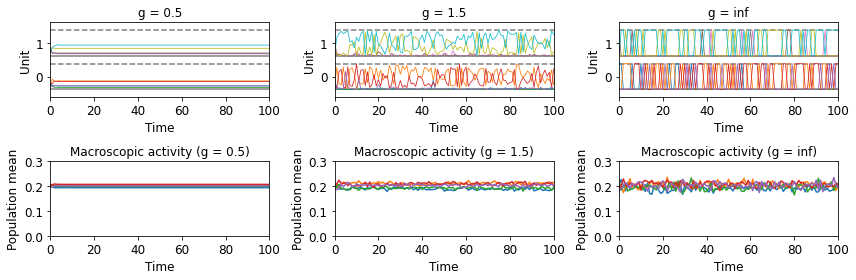

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(12, 4), tight_layout=True)
y_lim = (0, .3)
nplot = 2
iunits = np.random.permutation(N)[:nplot]

for cg, (g, rslt, ax_col) in enumerate(zip(gs, rslts, axs.T)):
    t, xs, ys = rslt
    
    # plot single unit traces
    y_off = 0
    y_ticks = []
    
    for iunit in iunits:
        ax_col[0].axhline(y_off, color='gray', ls='-')
        ax_col[0].axhline(y_off+1, color='gray', ls='--')
        ax_col[0].plot(t, ys[:, iunit, :] + y_off, lw=.8)
        
        y_ticks.append(y_off + .5)
        
        y_off += 1.3
    
    set_plot(ax_col[0], x_lim=(0, 100), y_lim=(-.3, y_off), y_ticks=y_ticks, y_tick_labels=range(nplot), x_label='Time', y_label='Unit', title=f'g = {g}')
    
    # plot mean-field param
    ax_col[1].plot(t, ys.mean(axis=1))
    
    set_plot(ax_col[1], x_lim=(0, 100), y_lim=y_lim, x_label='Time', y_label='Population mean', title=f'Macroscopic activity (g = {g})')
    
fig.savefig('figs/main/1_single_units_and_macro.svg')

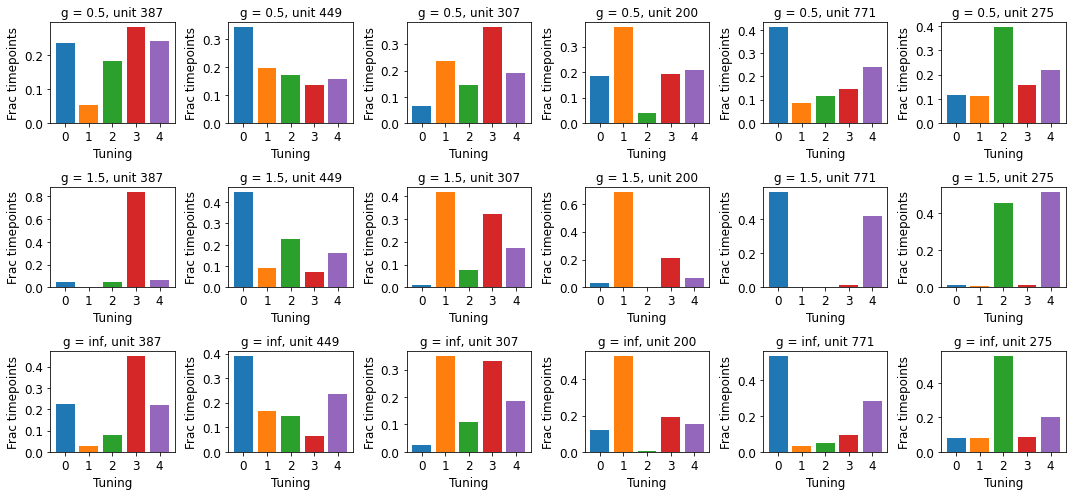

In [7]:
# example single-unit time averages
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
iunits = np.random.permutation(N)[:6]

fig, axs = plt.subplots(len(gs), len(iunits), figsize=(15, 7), tight_layout=True)

for cg, (g, rslt, ax_row) in enumerate(zip(gs, rslts, axs)):
    t, xs, ys = rslt
    for iunit, ax in zip(iunits, ax_row):
        ax.bar(np.arange(R), ys[:, iunit, :].mean(0), color=color_cycle)
        
        set_plot(ax, x_ticks=range(R), x_label='Tuning', y_label='Frac timepoints', title=f'g = {g}, unit {iunit}')
        
fig.savefig('figs/main/1_single_unit_time_avgs.svg')

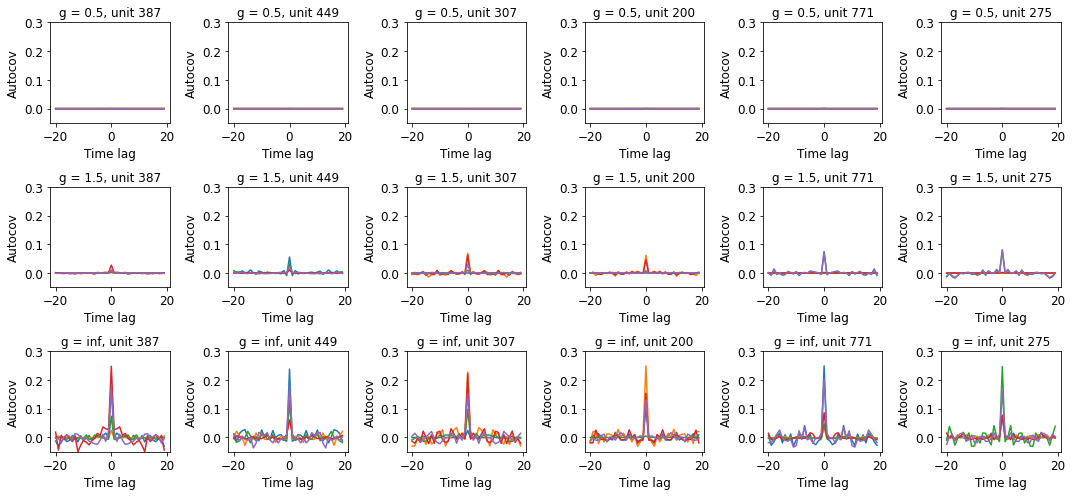

In [11]:
# example autocorrelation functions 
from time_stats import xcov_conv_tri

fig, axs = plt.subplots(len(gs), len(iunits), figsize=(15, 7), tight_layout=True)

for cg, (g, rslt, ax_row) in enumerate(zip(gs, rslts, axs)):
    ys = rslt[-1]
    for iunit, ax in zip(iunits, ax_row):
        for r, color in zip(range(R), color_cycle):
            y = ys[:, iunit, r]
            acov, t = xcov_conv_tri(y, y)
            mt = (-20 <= t)&(t < 20)
            ax.plot(t[mt], acov[mt], c=color)
        
        set_plot(ax, y_lim=(-.05, .3), x_label='Time lag', y_label='Autocov', title=f'g = {g}, unit {iunit}')
        
fig.savefig('figs/main/1_single_unit_autocovs.svg')

In [8]:
# run second network with larger R to get firing rate distribution
R2 = 12

J2 = np.nan*np.zeros((R2, R2, N, N))

for r_to in range(R2):
    for r_from in range(R2):
        J2[r_to, r_from, :, :] = np.random.randn(N, N)*np.sqrt(R2/N)
        
ntwk_2 = SoftmaxNtwk(J2)

x_0_2 = np.random.randn(N, R2)
t_2, xs_2, ys_2 = ntwk_2.run(g=np.inf, t_max=200, x_0=x_0_2, progress=10)

...................

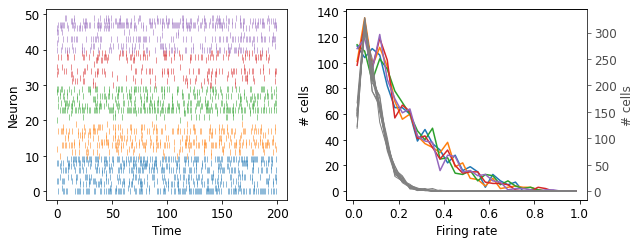

In [12]:
# raster plot and firing rate distributions for spiking limit
fig, axs = plt.subplots(1, 2, figsize=(9, 3.5), tight_layout=True)
t, xs, ys = rslts[-1]
nplot_cotuned = 10

for r in range(R):
    inrns = np.random.permutation(N)[:nplot_cotuned]
    tspks, cspks = ys[:, inrns, r].nonzero()
    axs[0].scatter(tspks, cspks+r*nplot_cotuned, marker='|', lw=.5)
    
set_plot(axs[0], x_label='Time', y_label='Neuron')

bins = np.linspace(0, 1, 31)
binc = .5*(bins[:-1] + bins[1:])

for r in range(R):
    rates = ys[:, :, r].mean(axis=0)  # time average
    cts_rate = np.histogram(rates, bins=bins)[0]
    
    axs[1].plot(binc, cts_rate)
    
# plot second set of histograms
ax_twin = axs[1].twinx()

for r in range(R2):
    rates = ys_2[:, :, r].mean(axis=0)
    cts_rate = np.histogram(rates, bins=bins)[0]
    
    ax_twin.plot(binc, cts_rate, c='gray', lw=1)
    
set_plot(ax_twin, y_label=f'# cells')
set_color(ax_twin, (.3, .3, .3))
    
set_plot(axs[1], x_label='Firing rate', y_label='# cells')

fig.savefig('figs/main/1_raster_and_firing_rate_distr.svg')